# Валидация - а зачем?

<center> <img src = 'https://scikit-learn.org/stable/_images/grid_search_workflow.png' width=900> </center>

* Sci-kit Learn https://scikit-learn.org/stable/modules/cross_validation.html

# Какие есть техники валидации?

* `KFold` - Кросс-итератор для K-фолдовой валидации
* `StratifiedKFold` - он же, но еще и стратифицированный (сбалансированный)
* `GroupKFold` - K-фрагментный вариант итератора с непересекающимися группами.
* `RepeatedKFold` - K-фолдная валидация с повторениями

* `StratifiedGroupKFold` - он же, но еще и стратифицированный (сбалансированный)
* `RepeatedStratifiedKFold` - а тут стратифицированный, но еще дополнительно с повторениями
* А где взять `RepeatedStratifiedGroupKFold`? :)

## Еще несколько 

* `Time Series Split`
* `Leave One Out (LOO)`
* `Leave One Group Out`

* `Leave P Out (LPO)`
* `Leave P Groups Out`

# Когда какую брать?
- Есть временная ось? -> `TimeSeriesSplit`
- Не много данных и быстро учится? -> `LeaveOneOut` 
- Много данных, но быстро учится? -> `KFold`
- Очень много данных и долго учится? -> старый добрый `train_test_split()`
- Есть дисбаланс классов? -> Любой итератор с приставкой `Stratified`
- Есть группы и нельзя допусть их одновременного присутствия в train и test? -> Любой итератор с приставкой `Group`

In [1]:
!pip install --upgrade seaborn pandas numpy -q
!pip install -U scikit-learn -q

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from tqdm.notebook import tqdm

In [3]:
!ls ../data/

car_info.csv   driver_info.csv	solution.csv	  tmp_driver_info.csv
car_test.csv   fix_info.csv	test_data.csv	  tmp_rides_info.csv
car_train.csv  rides_info.csv	tmp_car_info.csv


# Данные по машинам

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_2
2230,a-9975968Q,Skoda Rapid,economy,petrol,4.56,2014,700,2020,engine_check
1041,e-7981708c,VW Polo,economy,petrol,5.68,2015,23226,2016,break_bug
1724,S18526691D,Nissan Qashqai,standart,petrol,4.20,2011,48685,2019,another_bug
583,G-1367113F,Kia Rio X-line,economy,petrol,4.24,2015,11721,2019,wheel_shake
132,k22130724d,Nissan Qashqai,standart,petrol,4.72,2012,28988,2019,engine_overheat


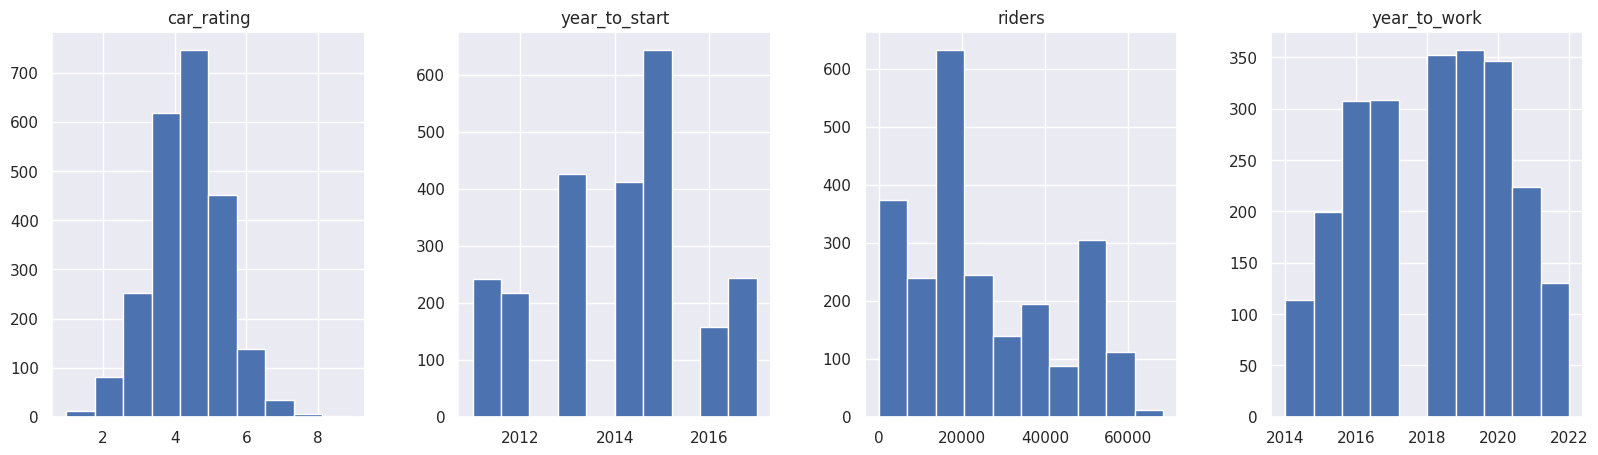

In [4]:
train = pd.read_csv('../data/car_train.csv').drop(['target_1'], axis=1, errors='ignore')
test = pd.read_csv('../data/car_test.csv').drop(['target_1', 'target_2'], axis=1, errors='ignore')

train.hist(figsize=(25, 5), layout = (-1, 5))
train.sample(5)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float64
 5   year_to_start  2337 non-null   int64  
 6   riders         2337 non-null   int64  
 7   year_to_work   2337 non-null   int64  
 8   target_2       2337 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 164.4+ KB


# Базовый feature engineering - генерируем и преобразуем признаки 

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
45830,O22349625h,C93651463z,K1d,2020-02-06,4.38,39,462,30,63.000000,2,1228.693383,0,-0.063697,-0.000
336102,A92613187m,X-4450516c,u1d,2020-02-27,3.24,160,1754,43,99.000000,12,2981.977460,0,-2.147851,-2.098
474689,V20924526z,g47240816d,u1R,2020-01-10,4.26,33,422,38,70.000000,1,852.129639,0,0.815877,0.000
735876,S18158773P,z20864667b,w1s,2020-01-17,2.88,296,2659,45,84.132560,8,2880.540077,0,-0.940785,11.893
244360,X51579957d,R-1017691X,l1T,2020-02-03,3.56,30,297,53,93.480872,1,1596.363084,0,8.328261,-7.841


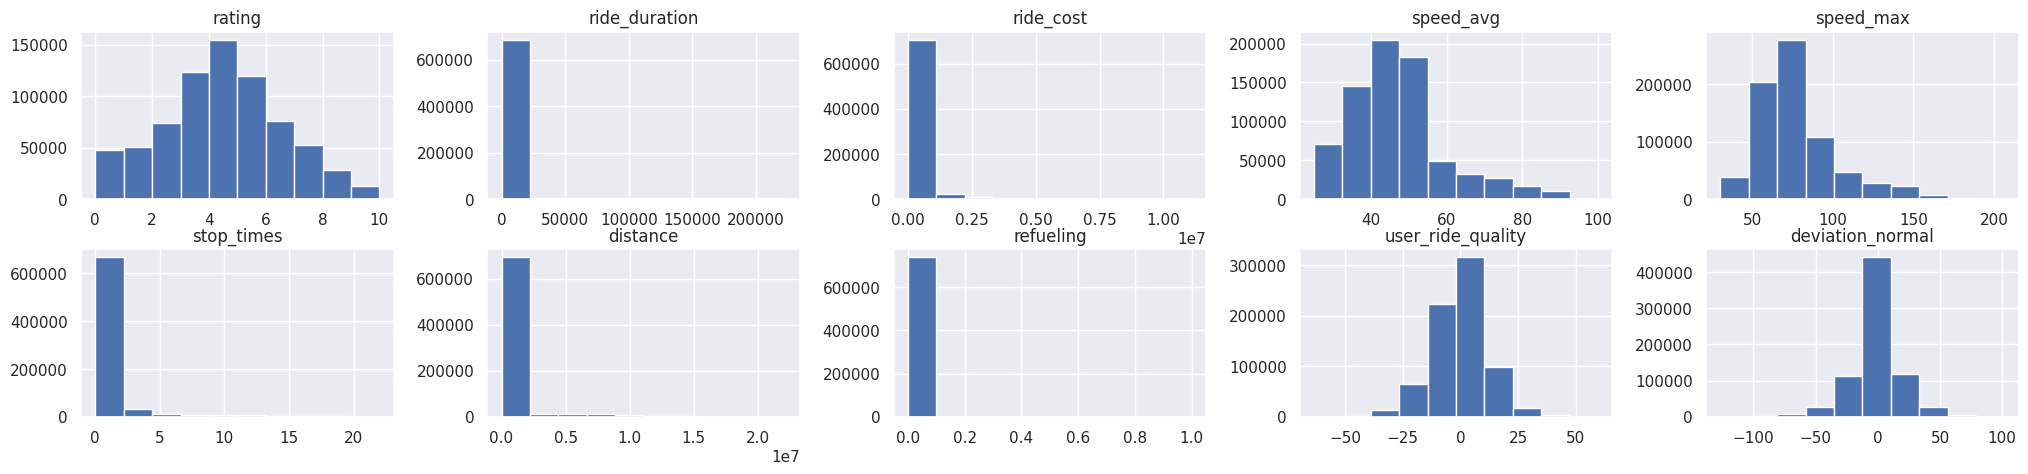

In [6]:
path = '../data/rides_info.csv' 
rides = pd.read_csv(path) # Данные по поездкам
rides.hist(figsize=(25, 5), layout = (-1, 5))
rides.sample(5)

In [7]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('speed_avg', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1068587k,44.390805,4.974618e+07,0.1,123.298894,12.530145,174,173
1,A-1122233S,50.310345,6.662596e+07,0.1,176.515698,-2.452621,174,173


In [8]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)

In [9]:
def make_one_hot(df, cols2one = ['car_type', 'fuel_type', 'model']):
    if 'car_type' in df.columns:
        for cat in cols2one:
            one_hot = pd.get_dummies(df[cat]) # выбрасываем старый столбец
            df = df.drop(cat, axis = 1)
            df = df.join(one_hot) # присоединяем закодированный фрагмент

    return df

train = make_one_hot(train)
test = make_one_hot(test)
train.head(4)

,car_id,car_rating,year_to_start,riders,year_to_work,target_2,mean_rating,distance_sum,rating_min,speed_max,...,Renault Sandero,Skoda Rapid,Smart Coupe,Smart ForFour,Smart ForTwo,Tesla Model 3,VW Polo,VW Polo VI,VW Tiguan,Volkswagen ID.4
0,Z16209094a,4.90,2016,30228,2017,engine_overheat,50.528736,7.489477e+07,0.1,166.954422,...,0,0,1,0,0,0,0,0,0,0
1,J-1559355B,4.42,2015,14651,2017,electro_bug,52.896552,7.429280e+07,0.0,184.182299,...,0,0,0,0,0,0,0,0,0,0
2,i14360916r,3.62,2017,56425,2019,another_bug,44.873563,5.388401e+07,0.1,118.000000,...,0,1,0,0,0,0,0,0,0,0
3,c47847702x,3.92,2013,19276,2017,electro_bug,49.959770,9.120220e+07,0.0,189.148125,...,0,0,0,0,0,0,0,1,0,0


# Классифицируем признаки

In [10]:
features2drop = ['car_id'] 
targets = ['target_2']  
cat_features = ['car_type', 'fuel_type', 'model'] 

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 43 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'business', 'economy', 'premium', 'standart', 'electro', 'petrol', 'Audi A3', 'Audi A4', 'Audi Q3', 'BMW 320i', 'Fiat 500', 'Hyundai Solaris', 'Kia Rio', 'Kia Rio X', 'Kia Rio X-line', 'Kia Sportage', 'MINI CooperSE', 'Mercedes-Benz E200', 'Mercedes-Benz GLC', 'Mini Cooper', 'Nissan Qashqai', 'Renault Kaptur', 'Renault Sandero', 'Skoda Rapid', 'Smart Coupe', 'Smart ForFour', 'Smart ForTwo', 'Tesla Model 3', 'VW Polo', 'VW Polo VI', 'VW Tiguan', 'Volkswagen ID.4 ']
targets ['target_2']


# Учим random forest с K-fold валидацией

In [47]:
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier

In [49]:
n_splits = 5 # # параметры валидации, обучение будет идти на n_splits (фолдах)
print('num folds', n_splits)
targets = ['target_2']


X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train[targets]

clfs = []
scores = []

kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for num, (train_index, test_index) in enumerate(kf.split(X)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # print(X_train.shape, y_train.shape)
    clf = RandomForestClassifier(n_estimators = 2_000,
                                 min_samples_leaf = 4,
                                 n_jobs = -1, 
                                 max_features = 0.60,
                                 # class_weight = 'balanced',
                                 random_state = 7575,
                                 max_depth = 6)
    clfs.append(clf)
    
    clf.fit(X_train, y_train['target_2'])

    y_pred = clf.predict(X_test)
    score = np.mean(np.array(y_pred == y_test['target_2']))
    scores.append(score)
    print(f'fold: {num} acc: {score}')

assert len(clfs) == n_splits
print('mean accuracy score --------->', np.mean(scores, dtype = 'float16'), np.std(scores).round(4))

num folds 5
fold: 0 acc: 0.5042735042735043
fold: 1 acc: 0.5149572649572649
fold: 2 acc: 0.5396145610278372
fold: 3 acc: 0.5781584582441114
fold: 4 acc: 0.563169164882227
mean accuracy score ---------> 0.54 0.0279


In [53]:
clfs = []
scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7575)

for train_index, test_index in kf.split(X = X, y = y['target_2'].tolist()):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # print(X_train.shape, y_train.shape)
    clf = RandomForestClassifier(n_estimators = 2_000,
                                 min_samples_leaf = 4,
                                 n_jobs = -1, 
                                 max_features = 0.60,
                                 # class_weight = 'balanced',
                                 random_state = 7575,
                                 max_depth = 6)
    clfs.append(clf)
    
    clf.fit(X_train, y_train['target_2'])

    y_pred = clf.predict(X_test)
    score = np.mean(np.array(y_pred == y_test['target_2']))
    scores.append(score)
    print(f'fold: acc: {score}')

assert len(clfs) == n_splits
print('mean accuracy score --------->', np.mean(scores, dtype = 'float16'), np.std(scores).round(4))

fold: acc: 0.5405982905982906
fold: acc: 0.5299145299145299
fold: acc: 0.5546038543897216
fold: acc: 0.5588865096359743
fold: acc: 0.5524625267665952
mean accuracy score ---------> 0.5474 0.0106


In [14]:
# test['target_2'] = 

# Делаем прогноз для теста (инференс)

In [26]:
path = 'https://stepik.org/media/attachments/lesson/779913/sample_submission.csv'
sub = pd.read_csv(path)

# массив для записи финального прогноза size*n_class
y_pred = np.zeros((sub.shape[0], train[targets].nunique()[0]))  # массив для финального прогноза size*n_class
scores = []
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(test[filtered_features])#[:,1]
    
f = lambda x: clf.classes_[x]
sub['target_2'] = list(map(f, y_pred.argmax(axis=1))) # size*n_class -> size
sub[['car_id', 'target_2']].to_csv('../subs/rforest_kfold.csv', index=False)
sub[['car_id', 'target_2']].head()

,car_id,target_2
0,I-1144396V,gear_stick
1,q13819346b,wheel_shake
2,O-1088987d,electro_bug
3,A-2091756g,wheel_shake
4,k15500468M,engine_ignition


car_info.csv	    demo_driver_info.csv  fix_info.csv	  tmp_car_info.csv
car_test.csv	    demo_fix_info.csv	  rides_info.csv  tmp_driver_info.csv
car_train.csv	    demo_rides_info.csv   solution.csv	  tmp_rides_info.csv
demo_car_train.csv  driver_info.csv	  test_data.csv


In [31]:
# pd.read_csv('../data/car_train.csv').sample(1000).to_csv('../data/demo_car_train.csv', index=False)
# pd.read_csv('../data/driver_info.csv').sample(1000).to_csv('../data/demo_driver_info.csv', index=False)
# pd.read_csv('../data/fix_info.csv').sample(1000).to_csv('../data/demo_fix_info.csv', index=False)
# pd.read_csv('../data/rides_info.csv').sample(50_000).to_csv('../data/demo_rides_info.csv', index=False)

# Feature Importance

Всего признаков 43 Усреднее по 5-ти моделям: 
На график нанесено топ-43 признаков


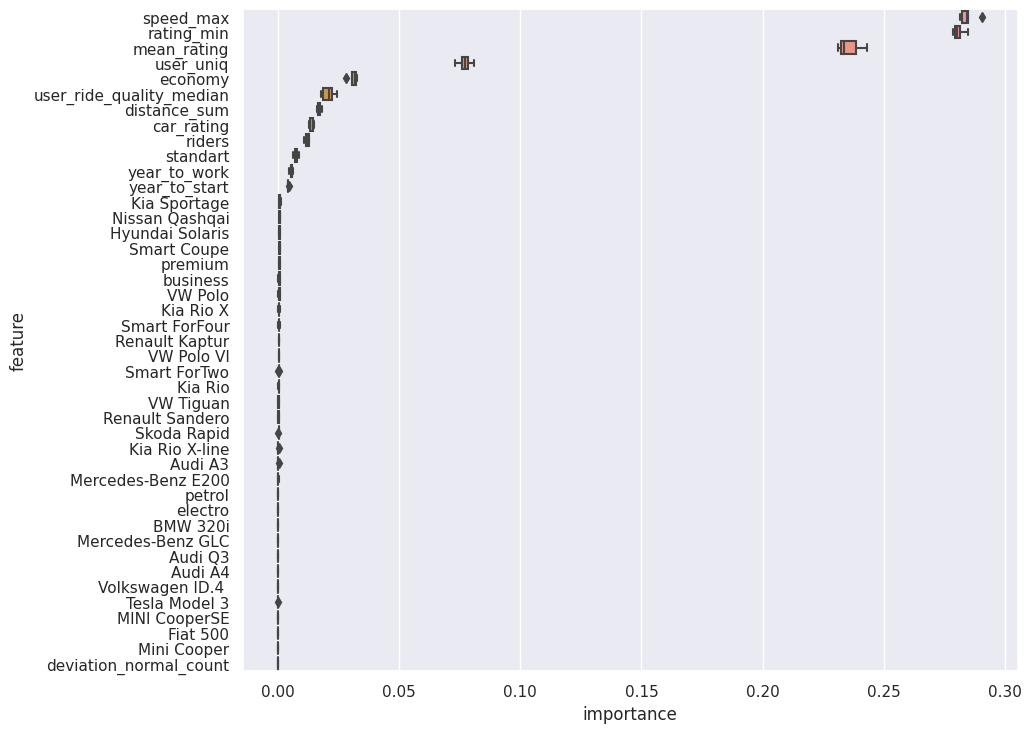

In [16]:
def plot_importance(df, best_model, height, top_n=50):
    
    top_n = min(top_n, df.shape[1])
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.feature_importances_

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков {} Усреднее по {}-ти моделям: '.format(len(cols_ord), len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(train[filtered_features].drop(targets, axis=1, errors='ignore'), clfs, 0.20, top_n=100)


# Данные по поездкам

In [17]:
rides_info = pd.read_csv('../data/rides_info.csv')
rides_info.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,I13186944D,A-1068587k,o1A,2020-01-01,3.51,80238,1043089,38,52.000000,3,3.128016e+06,0,-0.302421,-0.0
1,R97784496t,A-1068587k,F1X,2020-01-01,5.72,105756,1480577,45,64.000000,0,4.864626e+06,0,-0.499172,-0.0
2,I13694599a,A-1068587k,f1j,2020-01-02,5.57,5,60,73,93.602158,0,4.176389e+02,0,-1.548536,-5.0
3,T93834217S,A-1068587k,Q1u,2020-01-02,4.52,46,640,45,62.000000,0,2.122785e+03,0,-1.010666,-0.0
4,J40497939H,A-1068587k,C1X,2020-01-03,7.12,39,306,39,58.000000,1,1.261300e+03,0,-0.940802,-0.0


# Данные по ремонту и обслуживанию машин

In [18]:
fix_info = pd.read_csv('../data/fix_info.csv')
fix_info.head()

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,Z16209094a,PJ,2020-6-20 2:14,reparking,1.0,21
1,J-1559355B,ZJ,2020-2-9 20:25,repair,10.0,48
2,I-1144396V,KL,2019-8-24 7:1,reparking,1.0,27
3,i14360916r,CP,2019-8-10 9:29,reparking,1.0,28
4,q13819346b,VZ,2020-11-12 5:22,refuel_check,1.0,22


# Данные по водителям 

In [19]:
driver_info = pd.read_csv('../data/driver_info.csv')
driver_info.head()

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,9.0,865,18.0,m17437965Y,1,2019-4-2
1,46,7.9,2116,10.0,k12362316g,0,2021-11-19
2,59,8.1,947,5.0,P11098715I,0,2021-1-15
3,37,6.9,18,52.0,F12618125f,0,2019-11-20
4,39,8.3,428,7.0,F14375829N,0,2019-7-23
